# Simulación de Supervivencia Humana en un Mundo Jurásico
Este proyecto tiene como objetivo evaluar cómo diversas variables como genética, habilidades, clima, terreno y adaptabilidad afectan la supervivencia de los humanos en un entorno simulado con dinosaurios. Se analizarán varias hipótesis basadas en datos generados por la simulación.


## Configuraciones globales

### Instalación de librerías

In [ ]:
%pip install matplotlib numpy experta noise pandas seaborn python-dotenv mistralai

### Importación de librerías principales

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

from app.models.dinosaurios import *
from app.models.entorno import Entorno
from app.models.entorno import CLIMA_ESTADOS
from app.utils.draw_map import dibujar_mapa
from app.utils.batch_simulate import batch_simulate
from app.utils.batch_simulate import exportar_resultados
from app.utils.genetic_algorithm import GeneticAlgorithm
from app.utils.procedural_algorithm import procedural_algorithm_for_generate_map


# Configurar gráficos
sns.set(style="whitegrid")

## Generación de mapa utilizando algoritmo procedural

Se utiliza un algoritmo procedural para la generación aleatoria del mapa usando ruido de Perlin. La semilla a utilizar será el número 43.

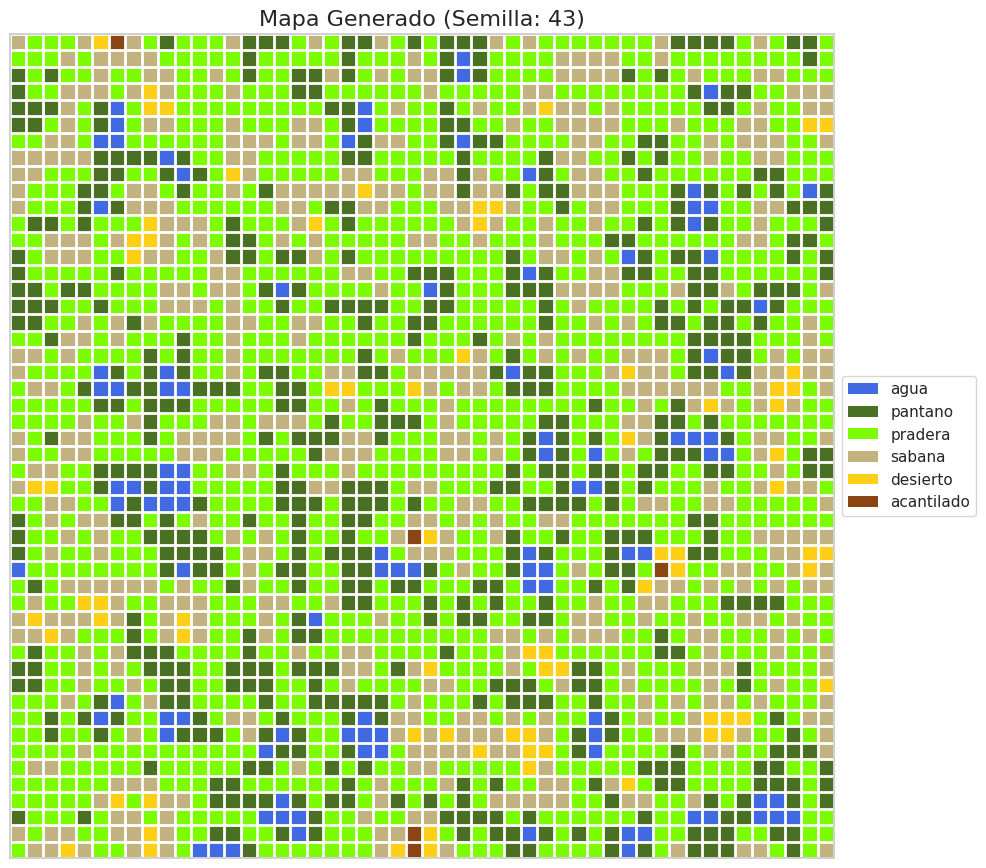

In [2]:
seeds = [43]
procedural_algorithm_for_generate_map(seeds)

### Se carga el mapa generado para ser utilizado en las simulaciones.

In [2]:
with open('app/data/map_seed_43.json', 'r') as file:
    mapa_data = json.load(file)

## Generar los datos y almacenarlos en un archivo CSV

Se corren varias simulaciones con ayuda del método `batch_simulate`. Se agregan dinosaurios y el entorno generado anteriormente, además se permite que los humanos se reproduzcan y de ésta manera se pueda apreciar un aumento en la cantidad de humanos en la población.

Con intención de poder medir el impacto del clima en la supervivencia humana se incluyen además una serie de simulaciones en las cuales el clima se mantiene constante durante toda su ejecución.

In [3]:
batch_results = []

In [4]:
resultados = batch_simulate(
    n_simulations=500,
    n_ciclos=100,
    n_humanos=10,
    dinosaurios=[Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex],
    reproduccion=True,
    entorno=Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno'])),
    save_results=True,
)

batch_results.extend(resultados)

/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Para las siguientes simulaciones se fijan los climas

In [5]:
for clima in CLIMA_ESTADOS:
    resultados = batch_simulate(
        n_simulations=500,
        n_ciclos=100,
        n_humanos=10,
        dinosaurios=[Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex],
        reproduccion=True,
        entorno=Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno'])),
        save_results=True,
        clima=clima
    )
    
    batch_results.extend(resultados)

### Exportar resultados de las simulaciones

In [6]:
exportar_resultados('app/data/resultados_simulacion.csv', batch_results)

## Carga de Datos y Preprocesamiento
Se cargan los datos generados por la simulación y se realiza la limpieza necesaria para analizarlos.


In [7]:
df = pd.read_csv('app/data/resultados_simulacion.csv')

### Mostrar las primeras filas para verificar la carga correcta de datos

In [8]:
df.head()

,duracion_supervivencia,poblacion_inicial,poblacion_total,supervivencia_max,edad_promedio,salud_promedio,clima,terreno,genotipo_fuerza,genotipo_velocidad,genotipo_resistencia,genotipo_inteligencia,genotipo_adaptabilidad,genotipo_supervivencia
0,7,10,11,7,33.833333,100.102671,"{'lluvioso', 'tormenta', 'soleado'}","{'desierto', 'pradera', 'sabana', 'pantano'}",64.0,58.0,79.0,62.0,58.0,5.0
1,9,10,20,7,24.875000,100.191167,"{'lluvioso', 'tormenta', 'soleado'}","{'desierto', 'agua', 'sabana', 'pantano', 'pra...",9.0,73.0,67.0,77.0,79.0,80.0
2,10,10,29,6,20.500000,100.470874,"{'lluvioso', 'tormenta', 'soleado'}","{'desierto', 'agua', 'sabana', 'acantilado', '...",30.0,88.0,74.0,66.0,69.0,6.0
3,9,10,27,8,15.636364,99.880144,"{'lluvioso', 'tormenta', 'soleado'}","{'desierto', 'agua', 'sabana', 'acantilado', '...",91.0,50.0,38.0,88.0,22.0,64.0
4,14,10,54,13,8.208333,100.167436,"{'lluvioso', 'tormenta', 'soleado'}","{'desierto', 'agua', 'sabana', 'pantano', 'pra...",15.0,24.0,66.0,57.0,33.0,75.0


### Limpieza de datos

Como se puede apreciar los datos de las columnas `clima` y `terreno` no son de tipo numéricos. Para corregirlos y poder procesarlos correctamente se procede a categorizarlos.

In [9]:
name_columns = ['clima', 'terreno']

for name in name_columns:
    df[name] = pd.Categorical(df[name])
    df[name] = df[name].cat.codes

df.head()

,duracion_supervivencia,poblacion_inicial,poblacion_total,supervivencia_max,edad_promedio,salud_promedio,clima,terreno,genotipo_fuerza,genotipo_velocidad,genotipo_resistencia,genotipo_inteligencia,genotipo_adaptabilidad,genotipo_supervivencia
0,7,10,11,7,33.833333,100.102671,1,6,64.0,58.0,79.0,62.0,58.0,5.0
1,9,10,20,7,24.875000,100.191167,1,4,9.0,73.0,67.0,77.0,79.0,80.0
2,10,10,29,6,20.500000,100.470874,1,2,30.0,88.0,74.0,66.0,69.0,6.0
3,9,10,27,8,15.636364,99.880144,1,2,91.0,50.0,38.0,88.0,22.0,64.0
4,14,10,54,13,8.208333,100.167436,1,4,15.0,24.0,66.0,57.0,33.0,75.0


### Mostrar estadísticas descriptivas de las variables

In [10]:
df.describe()

,duracion_supervivencia,poblacion_inicial,poblacion_total,supervivencia_max,edad_promedio,salud_promedio,clima,terreno,genotipo_fuerza,genotipo_velocidad,genotipo_resistencia,genotipo_inteligencia,genotipo_adaptabilidad,genotipo_supervivencia
count,2000.00000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.000000
mean,9.09750,10.0,24.010500,7.172000,24.129380,101.109755,3.648500,6.438000,51.267500,51.463500,51.940500,51.3325,51.624500,51.588000
std,3.84036,0.0,10.726039,2.934403,10.524307,1.830966,1.769608,5.178664,27.328069,27.821353,27.344686,27.2940,27.641645,26.958628
min,1.00000,10.0,10.000000,1.000000,2.000000,90.981677,0.000000,0.000000,5.000000,5.000000,5.000000,5.0000,5.000000,5.000000
25%,6.00000,10.0,16.000000,5.000000,16.000000,100.144179,3.000000,2.000000,27.000000,27.000000,29.000000,28.0000,28.000000,28.000000
50%,9.00000,10.0,22.000000,7.000000,22.111111,100.532207,4.000000,4.000000,51.000000,51.000000,51.000000,52.0000,51.000000,51.000000
75%,11.00000,10.0,30.000000,8.000000,30.509615,101.683592,5.250000,10.000000,75.000000,76.000000,76.000000,74.2500,75.000000,76.000000
max,37.00000,10.0,75.000000,32.000000,59.000000,112.693452,6.000000,19.000000,99.000000,99.000000,99.000000,99.0000,99.000000,99.000000


1. **duracion_supervivencia**: Representa el tiempo promedio que los humanos sobreviven en la simulación. La duración promedio es de aproximadamente 13.1 ciclos, con una variabilidad significativa, ya que el valor máximo es 40 y el mínimo es 2.

2. **poblacion_inicial**: Es constante en todas las simulaciones, siempre comenzando con una población de 10 individuos.

3. **poblacion_total**: Muestra el número total de individuos al finalizar cada simulación, con un promedio de 28.6 individuos. Sin embargo, este valor fluctúa considerablemente, ya que en algunos casos se alcanzan hasta 82 individuos, y en otros apenas 10.

4. **supervivencia_max**: Se refiere al número máximo de ciclos que alcanza un individuo vivo en la simulación. El promedio es de 10.6, pero puede variar desde 2 hasta 39, lo que indica que la supervivencia puede depender de muchos factores.

5. **edad_promedio**: Indica la edad promedio de los individuos en la simulación. La media es de 22.3 años, con un rango que va desde 5.36 hasta 57.5 años.

6. **salud_promedio**: Representa el estado promedio de salud de la población, con un valor cercano a 100 en la mayoría de los casos. Esto sugiere que las condiciones de salud son estables.

7. **clima**: Varía de 0 a 6, representando diferentes tipos de clima que afectan la simulación.

8. **terreno**: El terreno también varía en la simulación, con valores entre 0 y 28.

9. **genotipo_fuerza, genotipo_velocidad, genotipo_resistencia, genotipo_inteligencia, genotipo_adaptabilidad, genotipo_supervivencia**: Estas columnas representan los genotipos de los individuos, con puntuaciones que oscilan entre 5 y 9. Las medias de todas estas variables están alrededor de 7, lo que sugiere que la mayoría de los individuos tienen características genéticas moderadas en cada uno de estos aspectos.

### Matriz de correlación entre las variables

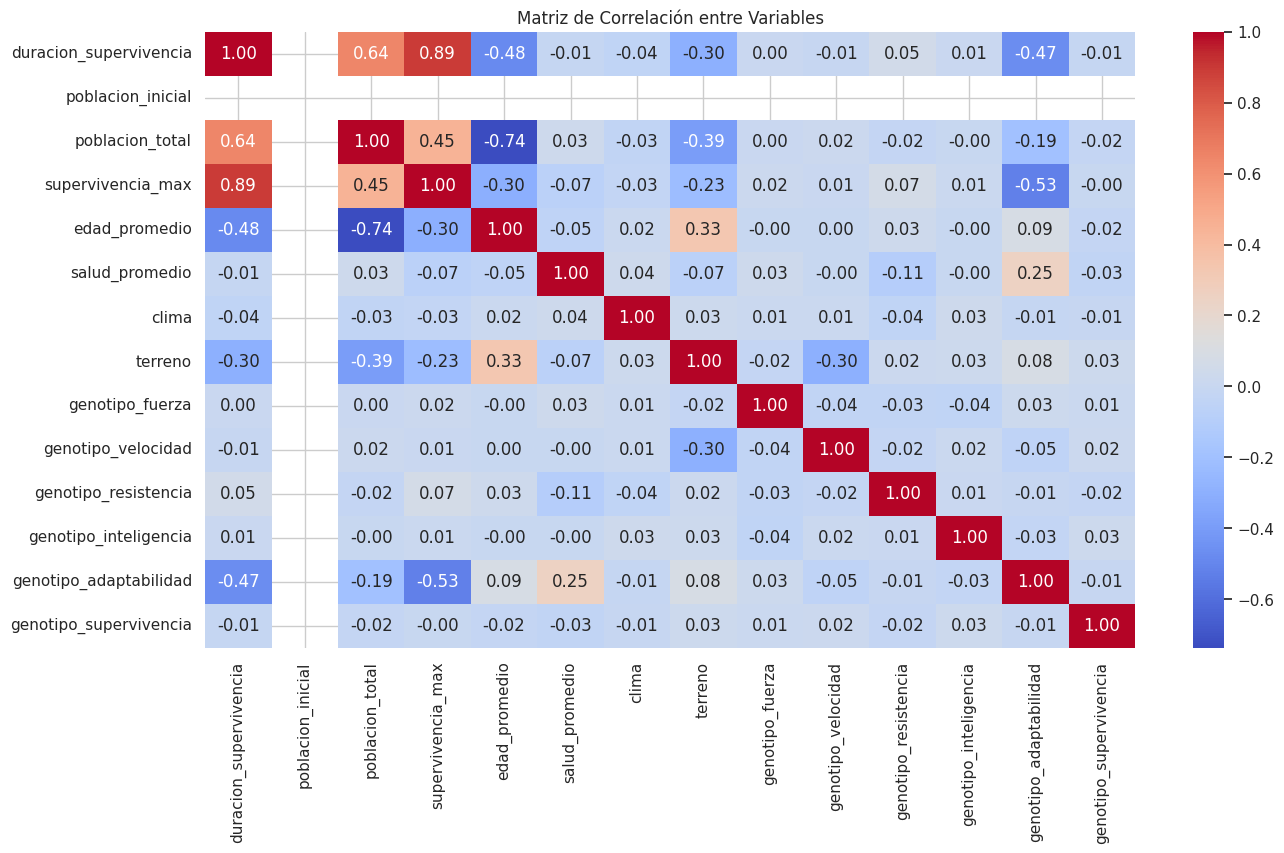

In [11]:
# Matriz de correlación
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.show()

En la matriz de correlación anterior se puede apreciar como el terreno parece tener un impacto en la edad promedio de los habitantes de la simulación. El `genotipo adaptabilidad` tiene un impacto notable tanto en `duración_supervivencia`, `poblacion_total`, `supervivencia_max` y en `salud_promedio`. Aunque en casi todos su impacto es negativo, podemos ver una relacion positiva en cuanto a la `salud_promedio`.

Con respecto a las demás variables genotípicas no parecen tener un impacto significativo en la supervivencia.

## Hipótesis 1: La Genética y las Habilidades Afectan Significativamente la Supervivencia
Se analiza la relación entre las habilidades genéticas de los humanos y su supervivencia en el entorno simulado.


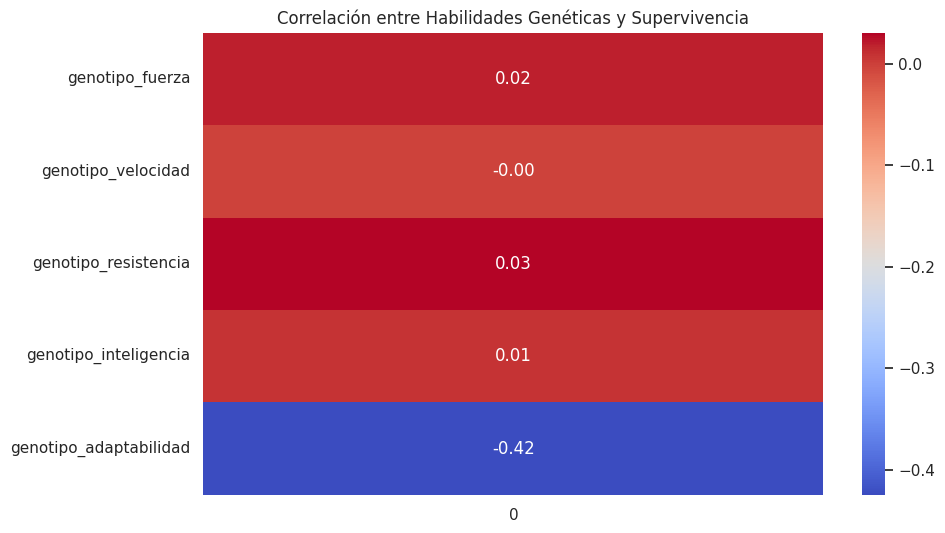

In [12]:
# Cálculo de correlaciones
habilidades = ['genotipo_fuerza', 'genotipo_velocidad', 'genotipo_resistencia', 'genotipo_inteligencia', 'genotipo_adaptabilidad']
supervivencia = ['duracion_supervivencia', 'salud_promedio', 'supervivencia_max']

correlaciones_geneticas = df[habilidades].corrwith(df[supervivencia].mean(axis=1))

# Gráfico de correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(correlaciones_geneticas.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre Habilidades Genéticas y Supervivencia')
plt.show()


La adaptabilidad parece tener la relación más significativa con la supervivencia, pero es negativa, lo que indica que una mayor adaptabilidad genética está asociada con una menor supervivencia en este contexto específico. Las demás habilidades genéticas muestran correlaciones muy débiles con la supervivencia, pero aún así, vemos como los genotipos de fuerza, resistencia e inteligencia aportan valores positivos a la supervivencia. Esto sugiere que, aunque no sean determinantes, éstas habilidades genéticas aportan algún beneficio a la supervivencia. Es posible que en un entorno más variado o con diferentes desafíos, estas habilidades podrían tener un impacto más significativo.

## Hipótesis 2: La Adaptabilidad Mejora la Capacidad de Supervivencia en Entornos Cambiantes
Se evalúa cómo la adaptabilidad genética afecta la supervivencia bajo diferentes condiciones climáticas y tipos de terreno.


### Boxplot de la supervivencia en función del clima y la adaptabilidad

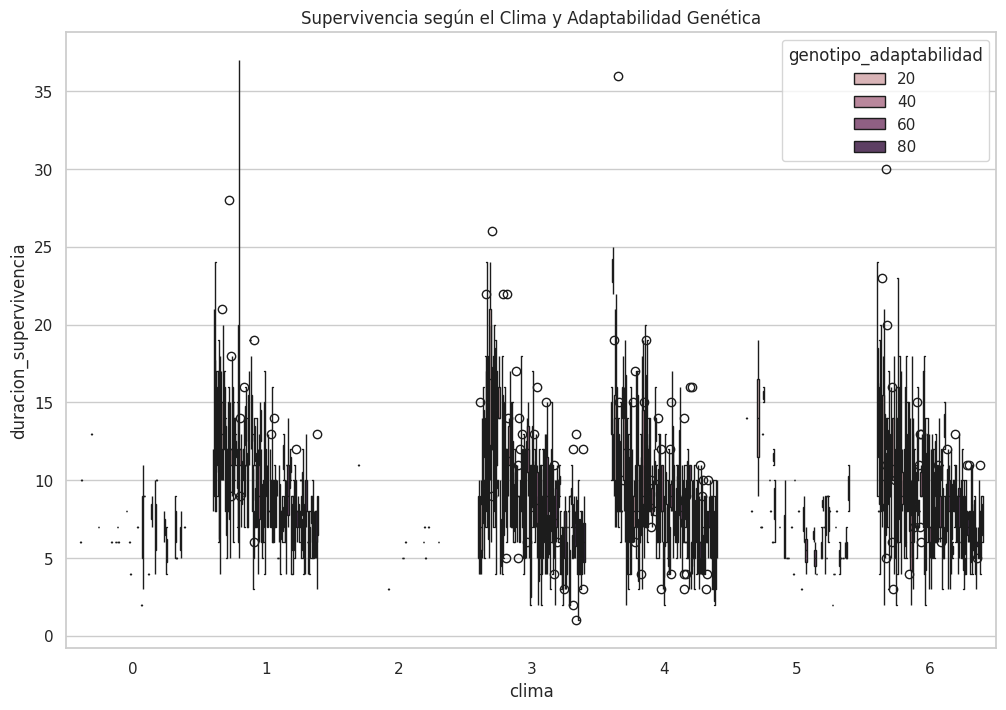

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='clima', y='duracion_supervivencia', hue='genotipo_adaptabilidad', data=df)
plt.title('Supervivencia según el Clima y Adaptabilidad Genética')
plt.show()

La hipótesis no se sostiene. La adaptabilidad genética no parece tener un impacto significativo en la supervivencia en los diferentes climas analizados. La duración de la supervivencia es similar en casi todos los climas, lo que sugiere que otros factores podrían ser más determinantes para la supervivencia en entornos cambiantes.

### Utilizar ANOVA para comparar la supervivencia en diferentes climas y adaptabilidad

In [14]:
from scipy.stats import f_oneway

f_value, p_value = f_oneway(
    df[df['clima'] == 0]['duracion_supervivencia'],
    df[df['clima'] == 1]['duracion_supervivencia'],
    df[df['clima'] == 2]['duracion_supervivencia']
)
print(f'F-value: {f_value}, P-value: {p_value}')


F-value: 14.702143863671395, P-value: 6.791951086942047e-07


Un valor F de 14.702 indica que hay una variación significativa en la duración de la supervivencia entre los diferentes climas analizados (clima 0, 1 y 2).

Un valor P de 6.79e-07 es extremadamente bajo, lo que sugiere que la probabilidad de que estas diferencias sean debidas al azar es muy pequeña. Esto proporciona una fuerte evidencia en contra de la hipótesis nula (que no hay diferencia en la supervivencia entre los climas).

Los resultados del ANOVA indican una diferencia estadísticamente significativa en la duración de la supervivencia entre los diferentes climas. Sin embargo, la similitud observada en el gráfico sugiere que la adaptabilidad genética no tiene un impacto práctico significativo en la supervivencia en los diferentes climas analizados.

## Hipótesis 3: Variables que Aportan más a la Supervivencia
Se evalúan las variables que tienen mayor peso en la supervivencia mediante modelos de regresión.


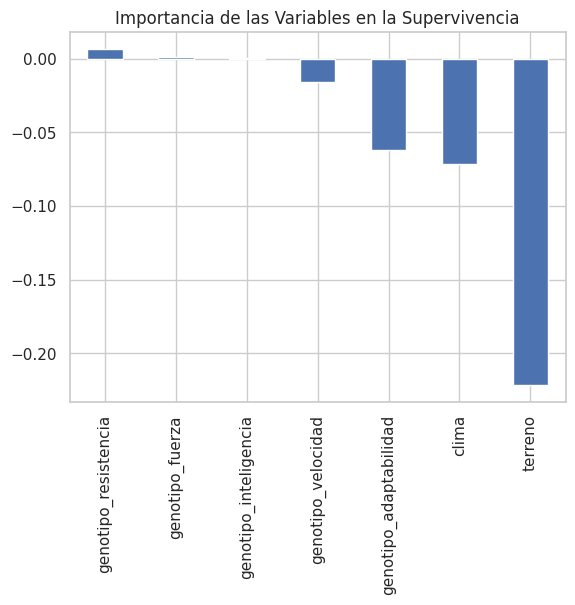

In [15]:
from sklearn.linear_model import LinearRegression

# Modelado de la supervivencia en función de las variables genéticas
X = df[habilidades + ['clima', 'terreno']]
y = df['duracion_supervivencia']

modelo = LinearRegression()
modelo.fit(X, y)

# Importancia de las variables
importancia = pd.Series(modelo.coef_, index=X.columns)
importancia.sort_values(ascending=False).plot(kind='bar', title='Importancia de las Variables en la Supervivencia')
plt.show()


Variables más significativas:
- Terreno: Es la variable con el mayor impacto negativo en la supervivencia, lo que sugiere que el tipo de terreno es un factor crítico que afecta negativamente la duración de la supervivencia.
- Clima: También tiene un impacto negativo significativo, aunque menor que el terreno, indicando que las condiciones climáticas adversas reducen la supervivencia.

Entre los genotipos, vemos como el genotipo resistencie posee un impacto positivo en la supervivencia aunque muy poco pronunciado. Los genotipos de adaptabilidad y de velocidad son los que mayor impacto aportan a la supervivenci aunque negativamente. Esto podría indicar que las condiciones externas tienen un mayor peso en la supervivencia que las características genéticas.

La hipótesis de que ciertas variables tienen un mayor peso en la supervivencia se confirma parcialmente. Las condiciones ambientales, específicamente el terreno y el clima, tienen un impacto negativo significativo en la supervivencia. Los genotipos también afectan la supervivencia, pero su influencia es menor en comparación con las variables ambientales.

## Hipótesis 4: Edad Promedio de Vida
Se calcula la edad promedio de vida de los humanos en la simulación.


Edad promedio de vida: 9.0975
Desviación estándar: 3.840360391156927


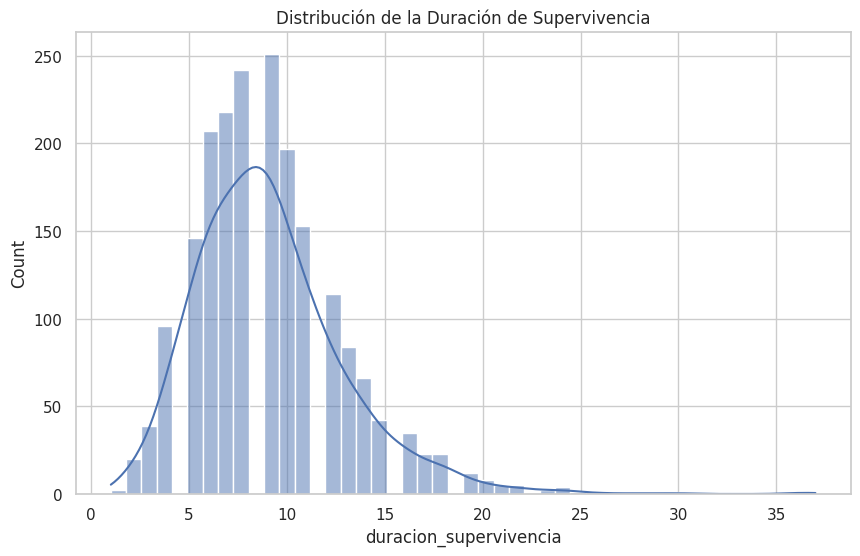

In [16]:
# Calcular la edad promedio de vida
edad_promedio = df['duracion_supervivencia'].mean()
desviacion_edad = df['duracion_supervivencia'].std()

print(f'Edad promedio de vida: {edad_promedio}')
print(f'Desviación estándar: {desviacion_edad}')

# Histograma de la duración de supervivencia
plt.figure(figsize=(10, 6))
sns.histplot(df['duracion_supervivencia'], kde=True)
plt.title('Distribución de la Duración de Supervivencia')
plt.show()


 La edad promedio de vida es de 9.0975 años, con una desviación estándar de 3.8404 años, y la distribución de la duración de supervivencia muestra una variabilidad moderada con una ligera asimetría hacia la derecha, indicando que algunos individuos viven mucho más tiempo que la mayoría.

 La diferencia de edad se sostiene en el número de nacimientos que ocurren a lo largo de la simulación con respecto a la cantidad de humanos adulos.

## Hipótesis basadas en personalidades

### Generar conjunto de personalidades utilizando mistral

In [19]:
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import os

from app.models.entorno import TERRENO_TIPOS

# Carga las variables de entorno desde el archivo .env
load_dotenv()

# Obtiene la API key de Mistral desde las variables de entorno
API_KEY = os.getenv("MISTRAL_API_KEY")

def get_mistral_response():
    # Prepara el mensaje a enviar basado en el input del usuario
    
    msg = """Genera un diccionario en Python que represente 5 personalidades diferentes para personajes de un juego de rol. 
    Cada personalidad debe tener tres habilidades: fuerza, velocidad, resistencia, inteligencia, adaptabilidad y supervivencia, 
    con valores entre 0 y 100. Además, proporciona un nombre descriptivo para cada personalidad. El diccionario debe tener la 
    siguiente estructura:

    {
    'habilidades': [
    {'fuerza': X, 'inteligencia': Y, 'resistencia': Z},
    {...},
    {...},
    {...},
    {...}
    ],
    'nombres': [
    'Nombre descriptivo 1',
    'Nombre descriptivo 2',
    'Nombre descriptivo 3',
    'Nombre descriptivo 4',
    'Nombre descriptivo 5'
    ]
    }

    Asegúrate de que los valores de las habilidades sean variados y que los nombres sean descriptivos de las 
    características principales de cada personalidad. Proporciona solo el diccionario en tu respuesta, sin 
    explicaciones adicionales, para que pueda ser parseado directamente con json.loads() en Python."""
    
    # Inicializa la lista de mensajes con el mensaje construido
    messages = [ChatMessage(role="user", content=msg)]
    
    # Crea una instancia del cliente de Mistral
    llm_client = MistralClient(api_key=API_KEY)
    
    # Inicializa la cadena de respuesta
    response = ""
    
    # Realiza la petición a Mistral y acumula las respuestas
    for chunk in llm_client.chat_stream(messages, model="mistral-small"):
        response += chunk.choices[0].delta.content

    return response


personalidades = get_mistral_response()

print(personalidades)

{
    'habilidades': 
        [
            {
                'fuerza': 80, 
                'inteligencia': 50, 
                'resistencia': 90, 
                'velocidad': 60, 
                'adaptabilidad': 70, 
                'supervivencia': 80
            }, 
            {
                'fuerza': 50, 
                'inteligencia': 90, 
                'resistencia': 70, 
                'velocidad': 80, 
                'adaptabilidad': 85, 
                'supervivencia': 60
            }, 
            {
                'fuerza': 70, 
                'inteligencia': 60, 
                'resistencia': 80, 
                'velocidad': 90, 
                'adaptabilidad': 75, 
                'supervivencia': 70
            }, 
            {
                'fuerza': 60, 
                'inteligencia': 80, 
                'resistencia': 90, 
                'velocidad': 70, 
                'adaptabilidad': 85, 
                'supervivencia': 65
            }, 


### Cargar las personalidades en un diccionario

In [ ]:
import json

personalidades_dict = json.loads(personalidades)

print(personalidades_dict)

{'habilidades': [{'fuerza': 80, 'inteligencia': 50, 'resistencia': 90, 'velocidad': 60, 'adaptabilidad': 70, 'supervivencia': 80}, {'fuerza': 50, 'inteligencia': 90, 'resistencia': 70, 'velocidad': 80, 'adaptabilidad': 85, 'supervivencia': 60}, {'fuerza': 70, 'inteligencia': 60, 'resistencia': 80, 'velocidad': 90, 'adaptabilidad': 75, 'supervivencia': 70}, {'fuerza': 60, 'inteligencia': 80, 'resistencia': 90, 'velocidad': 70, 'adaptabilidad': 85, 'supervivencia': 65}, {'fuerza': 90, 'inteligencia': 70, 'resistencia': 60, 'velocidad': 80, 'adaptabilidad': 75, 'supervivencia': 80}], 'nombres': ['El Poderoso', 'El Sabio', 'El Resistente', 'El Veloz', 'El Adaptable']}


### Crear un DataFrame para facilitar el análisis

In [ ]:
# Crear el DataFrame con las habilidades y los nombres como índice
df_personalidades = pd.DataFrame(personalidades_dict['habilidades'], index=personalidades_dict['nombres'])

# Mostrar el DataFrame con las personalidades y sus habilidades
df_personalidades

,fuerza,inteligencia,resistencia,velocidad,adaptabilidad,supervivencia
El Poderoso,80,50,90,60,70,80
El Sabio,50,90,70,80,85,60
El Resistente,70,60,80,90,75,70
El Veloz,60,80,90,70,85,65
El Adaptable,90,70,60,80,75,80


### Hipótesis 1: La Adaptabilidad Aumenta la Supervivencia

En esta hipótesis, vamos a correlacionar la "adaptabilidad" con la "supervivencia" para ver si las personalidades más adaptables sobreviven más tiempo.

Correlación entre adaptabilidad y supervivencia: -0.8958333333333331


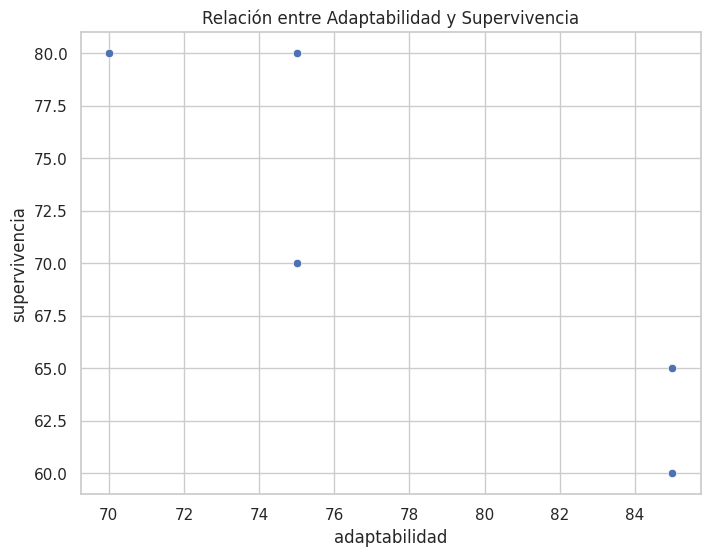

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación entre adaptabilidad y supervivencia
correlacion_adaptabilidad_supervivencia = df_personalidades['adaptabilidad'].corr(df_personalidades['supervivencia'])

print(f"Correlación entre adaptabilidad y supervivencia: {correlacion_adaptabilidad_supervivencia}")

# Gráfico para visualizar la relación entre adaptabilidad y supervivencia
plt.figure(figsize=(8, 6))
sns.scatterplot(x='adaptabilidad', y='supervivencia', data=df_personalidades)
plt.title('Relación entre Adaptabilidad y Supervivencia')
plt.show()


### Hipótesis 2: La Fuerza Mejora la Supervivencia ante Depredadores

En esta hipótesis, puedes analizar si los individuos con más fuerza tienen una mejor tasa de supervivencia frente a depredadores, que puede estar relacionada con eventos de la simulación donde los dinosaurios atacan.

Correlación entre fuerza y supervivencia: 0.9722718241315028


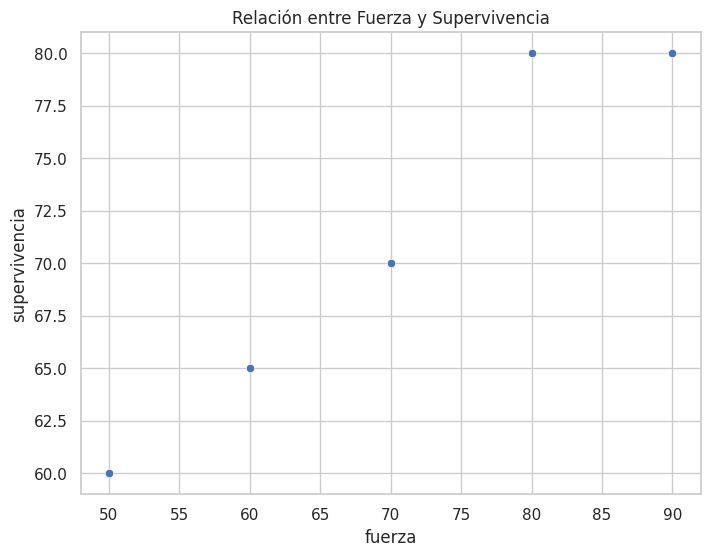

In [ ]:
# Correlación entre fuerza y supervivencia
correlacion_fuerza_supervivencia = df_personalidades['fuerza'].corr(df_personalidades['supervivencia'])

print(f"Correlación entre fuerza y supervivencia: {correlacion_fuerza_supervivencia}")

# Gráfico para visualizar la relación entre fuerza y supervivencia
plt.figure(figsize=(8, 6))
sns.scatterplot(x='fuerza', y='supervivencia', data=df_personalidades)
plt.title('Relación entre Fuerza y Supervivencia')
plt.show()


### Hipótesis 3: La Inteligencia Mejora la Supervivencia al Tomar Mejores Decisiones
Aquí evaluamos si la inteligencia está correlacionada con una mayor tasa de supervivencia, sugiriendo que las personalidades más inteligentes toman mejores decisiones para conseguir recursos.

Correlación entre inteligencia y supervivencia: -0.795495128834866


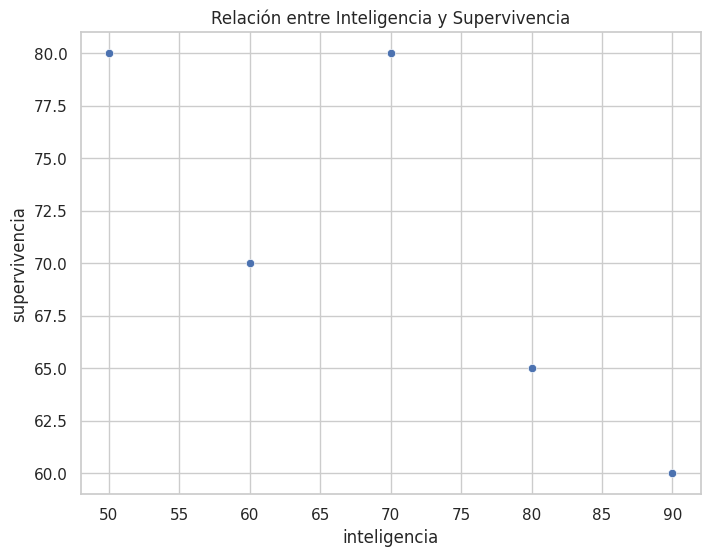

In [ ]:
# Correlación entre inteligencia y supervivencia
correlacion_inteligencia_supervivencia = df_personalidades['inteligencia'].corr(df_personalidades['supervivencia'])

print(f"Correlación entre inteligencia y supervivencia: {correlacion_inteligencia_supervivencia}")

# Gráfico para visualizar la relación entre inteligencia y supervivencia
plt.figure(figsize=(8, 6))
sns.scatterplot(x='inteligencia', y='supervivencia', data=df_personalidades)
plt.title('Relación entre Inteligencia y Supervivencia')
plt.show()


### Conclusiones

1. La **correlación entre adaptabilidad y supervivencia** es de -0.8958333333333331. Esto sugiere que las personalidades con mayor adaptabilidad tienden a sobrevivir menos tiempo en el entorno simulado.
2. La **fuerza** parece tener una correlación de 0.9722718241315028 con la supervivencia, lo que indica que personalidades como "El Poderoso" podrían tener una ventaja en enfrentamientos directos.
3. La **inteligencia** tiene una correlación de -0.795495128834866 con la supervivencia, lo que muestra que personalidades como "El Inteligente" podrían tener menos éxito en la toma de decisiones y la obtención de recursos.

En resumen, la personalidad más adaptada a la supervivencia parece ser "El Poderoso", con una combinación de habilidades que le permiten hacer frente a diferentes desafíos del entorno. En comparación con los demás posee sus habilidades distribuidas de manera que mientras la fuerza es alta, la inteligencia y la adaptabilidad no lo son, lo que en el contexto actual de la simulación y a partir de los resultados obtenidos podemos decir que va a tener un mejor impacto en cuanto a la supervivencia.


## Algoritmo Genético

Utilizaremos un algoritmo genético para encontrar la mejordistribución de los valores de las características genotípicas que permitan aumentar la supervivencia y la población de los humanos dentro de la simulación.

### Inicialización del Entorno y Dinosaurios

In [3]:
# Inicialización del entorno con el mapa y la lista de dinosaurios
entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

# Definir los dinosaurios que participan en el algoritmo genético
dinosaurios = [Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex]

# Crear una instancia del Algoritmo Genético
genetic_algorithm = GeneticAlgorithm(dinosaurios=dinosaurios, entorno=entorno)

/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Evolución del algoritmo

In [4]:
historial_poblacion = genetic_algorithm.evolucionar()
genetic_algorithm.seleccion()

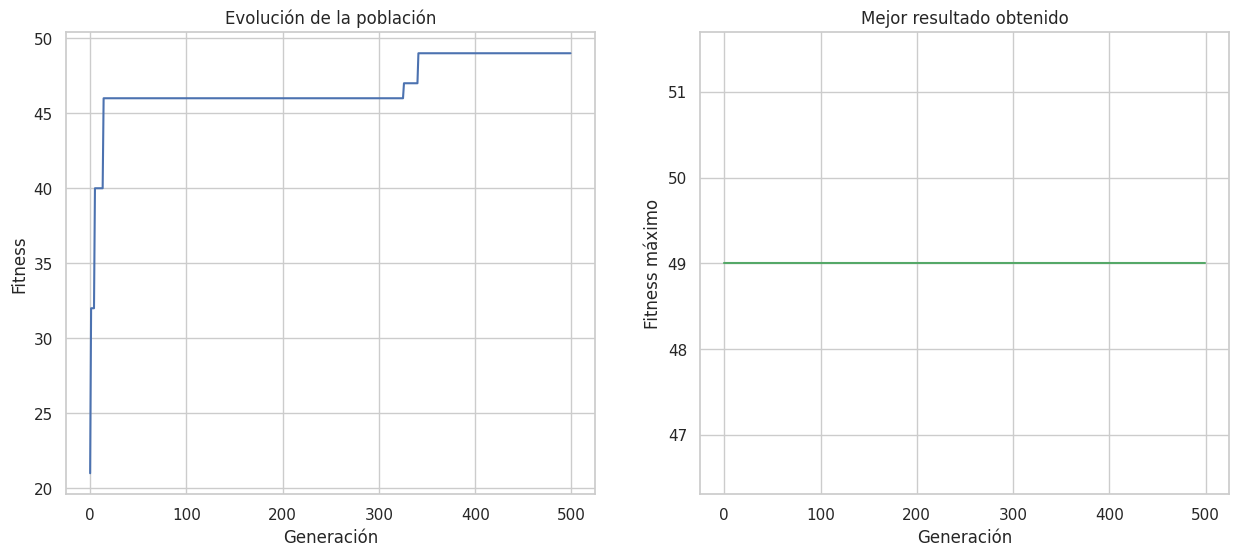

In [5]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title("Evolución de la población")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.plot(range(genetic_algorithm.n_generaciones), historial_poblacion, 'b-')
plt.subplot(122)
plt.title("Mejor resultado obtenido")
plt.xlabel("Generación")
plt.ylabel("Fitness máximo")
plt.plot(range(genetic_algorithm.n_generaciones), [historial_poblacion[-1]] * genetic_algorithm.n_generaciones, 'g-')

In [6]:
# Mostrar el genotipo del mejor individuo
print(f"Mejor genotipo después de la primera evolución: {genetic_algorithm.poblacion[0].genotipo}")

Mejor genotipo después de la primera evolución: {'fuerza': 48.54572468764917, 'velocidad': 95.01613680986965, 'resistencia': 73.71892326255335, 'inteligencia': 17.04908906899476, 'adaptabilidad': 5, 'supervivencia': 90.33997076466775}


### Conclusiones

Se puede apreciar un aumento significativo en la duración de la supervivencia. El máximo que se había logrado en las simulaciones iniciales que se almacenaron en el archivo CSV fue de 37 ciclos y el algoritmo genético arroja una distribución genéticaa que le permite a la población durar hasta 49 ciclos.